In [133]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import os
import math
import codecs
from collections import Counter
from nltk import word_tokenize
from gensim.models import Word2Vec
import spacy
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors


from feature_extraction import TextFeatureCreator

def roundup(x):
    return int(math.ceil(x / 10.0)) * 10

In [ ]:
#import zipfile
#zip_ref = zipfile.ZipFile("clean_newsela_article_files.zip", 'r')
#zip_ref.extractall("clean_newsela")
#zip_ref.close()

In [67]:
nlp = spacy.load('en_core_web_sm')

# Attention Based Neural Networks

## Import Section

### Dataset

In [68]:
#import training and test set
df = pd.read_csv("/data/ts_cost_function/newsela_article_feature_scores.csv",sep=";")
len(df)

21490

### Text Scorer

In [69]:
#import Scorer
ts = TextFeatureCreator("/data/ts_cost_function/LSATtexts.txt")

In [3]:
ts.feature_max

array([4.60611227e+00, 3.10202027e+01, 3.18078798e-01, 4.72160037e+01,
       4.57929050e-01, 7.43301324e+00, 4.42320513e+00, 2.82743677e+00,
       1.52766676e+00, 1.39530366e+00, 1.87133128e+00, 1.08050328e+00,
       6.62886357e-01, 1.08484166e+00, 1.20740261e-01, 3.11994654e-01,
       1.65647696e-02, 1.52961211e+00, 1.98660670e-01, 3.44356431e+00,
       3.82638558e+00])

## Explore Dataset

### Number of different Tokens

In [70]:
test_path = "/data/ts_cost_function/clean_newsela/"
#test_path = test_path[:5] + "clean_" + test_path[5:]

In [71]:
def yield_file_text(df):
    for ind,row in df.iterrows():
        if row["path"] != 'data/LSATtexts.txt':
            yield get_file_text(row,tokenize=False)

In [126]:
def get_file_text(row,tokenize=True):
    path = row["path"].split("/")[-1]
    path= "/data/ts_cost_function/clean_newsela/"+path
    #if row["dataset"] == "newsela":
    #    path = row["path"][:5] + "clean_" + row["path"][5:]
    with codecs.open(path, "r",encoding='utf-8', errors='ignore') as f:
        text = f.read()
        if tokenize:
            text = [[word.text.lower() for word in nlp(sent)] for sent in text.split(".")]
        return text

In [73]:
def load_eng_words(eng_words_path="data/20k_words.txt"):

    with open(eng_words_path,"r") as f:
        data = f.read()
        words = data.split("\n")
        english_df = pd.DataFrame(data=words,columns=["word"])
        english_df["index"] = range(0,len(english_df))
    return english_df

In [ ]:
texts = [get_file_text(row) for ind,row in tqdm(df.iterrows()) if row["path"] != 'data/LSATtexts.txt']

In [ ]:
#word_set = set()
counter = Counter()
for ind,row in tqdm(df.iterrows()):
    lem_text = [token.lemma_ for token in nlp(get_file_text(row))]
    counter.update(lem_text)

In [23]:
with open("data/newsela_word_set.txt","w") as f:
    f.write(",".join(word_set))
    f.close()

In [47]:
word_array = np.array(list(word_set))
english_df = load_eng_words()
len(word_set.intersection(english_df["word"].values))

15419

### Number of Sentences and Words per Sentence

In [74]:
def sentence_stats(df):
    sents = []
    words = []
    removed = []
    for ind,text in enumerate(yield_file_text(df)):
        sent_split = text.split(".")
        sents.append(len(sent_split))
        words.append([word_tokenize(sent) for sent in sent_split])
        if text.find("This article has been removed") >= 0:
            removed.append(ind)
    
    print("Max #Sents: {}".format(np.max(sents)))
    print("Min #Sents: {}".format(np.min(sents)))
    print("Std #Sents: {}".format(np.std(sents)))
    plt.boxplot(sents)
    plt.show()
    
    return sents,words,removed

Max #Sents: 224
Min #Sents: 14
Std #Sents: 14.115212574729066


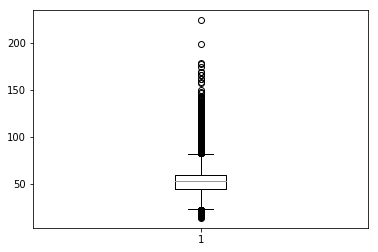

In [76]:
sents,words,removed = sentence_stats(df)

In [96]:
words = np.array([np.array([len(sent) for sent in sents]) for sents in removed])

In [109]:
#Max Word Count
np.max([np.max(article) for article in words])

484

In [110]:
#Mean Word Count
np.mean([sent for art in words for sent in art])

14.720281280318863

# Input Data

## Word Embedding

### train word2vec

In [28]:

with codecs.open("data/clean_newsela/3d-print-hand-violin-22566-1320.txt", "r",encoding='utf-8', errors='ignore') as f:
    example = f.read()
    example = [[token.text.lower() for token in nlp(prefix_whitespace.sub("",sent))] for sent in example.split(".")]

In [13]:
prefix_whitespace = re.compile("^ +")

class WordTrainer(object):
    def __init__(self, dir_name):
        self.dir_name = dir_name
    def __iter__(self):
        for idx,file_name in enumerate(os.listdir(self.dir_name)):
            for idxx,text in enumerate(
                codecs.open(
                    os.path.join(self.dir_name, file_name),'r',encoding='utf-8', errors='ignore')):
                
                sents = [[token.text.lower() 
                          for token in nlp(prefix_whitespace.sub("",sent))] 
                         for sent in text.split(".")]
                for words in sents:
                    yield words
                


In [ ]:
patient_details = WordTrainer('/data/ts_cost_function/clean_newsela/')
word_vector_model = Word2Vec(patient_details, size=100, window=4, min_count=5)


In [16]:
word_vector_model.save("/data/ts_cost_function/word2vec.model")

In [114]:
word_vector_model = Word2Vec.load("/data/ts_cost_function/word2vec.model")

### Use predefined word embedding

In [119]:
#model = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)

In [120]:
def yield_token_vectors(df,word2vec_model):
    for ind,row in df.iterrows():
        if row["path"] != 'data/LSATtexts.txt':
            tok_text =  get_file_text(row,tokenize=True)
            yield vetorize_tokens(tok_text,word2vec_model)

In [129]:
def vetorize_tokens(tok_text,word2vec_model):
    vector_text = []
    for sent in tok_text:
        vector_sent = []
        for token in sent:
            try:
                vector_sent.append(word2vec_model.wv[token])
            except KeyError:
                pass
        vector_text.append(vector_sent)
    return vector_text

In [131]:
def train_word_emb_fn(df,word2vec_model, batch_size):
    """An input function for training"""
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((yield_token_vectors(df,word2vec_model), df["regression_score"]))

    # Shuffle, repeat, and batch the examples.
    dataset = dataset.shuffle(1000).repeat().batch(batch_size)

    # Return the dataset.
    return dataset

In [134]:
train_word_emb_fn(df,word_vector_model,10)

TypeError: Failed to convert object of type <class 'generator'> to Tensor. Contents: <generator object yield_token_vectors at 0x7f9aad9f74c0>. Consider casting elements to a supported type.

In [ ]:
def eval_word_emb_fn(features, labels=None, batch_size=None):
    """An input function for evaluation or prediction"""
    if labels is None:
        # No labels, use only features.
        inputs = features
    else:
        inputs = (features, labels)

    # Convert inputs to a tf.dataset object.
    dataset = tf.data.Dataset.from_tensor_slices(inputs)

    # Batch the examples
    assert batch_size is not None, "batch_size must not be None"
    dataset = dataset.batch(batch_size)

    # Return the read end of the pipeline.
    return dataset.make_one_shot_iterator().get_next()

## Sentence Words

## Character Level

# NN Architecture

## Embedding + Sentence RNN + Text RNN

The sentence RNN will output a hidden state for each sentence. Afterwards each hidden state will be used as a input for another RNN on text level. The final output is than the score.

In [ ]:
def model_emb_cnn_rnn_fn(features, labels, mode):
    
    input_layer = 

## Embedding + Conv + RNN

Taghipour, Kaveh, and Hwee Tou Ng. "A neural approach to automated essay scoring." Proceedings of the 2016 Conference on Empirical Methods in Natural Language Processing. 2016.

![alt text](A_Neural_Approach_to_Automated_Essay_Scoring.PNG)

In [ ]:
def model_emb_cnn_rnn_fn(features, labels, mode):
    """Model function for CNN."""
    # features = words
    input_layer = tf.reshape(features, [-1, 28, 28, 1])

    # Convolutional Layer #1
    #conv1 = tf.layers.conv2d(
    #  inputs=input_layer,
    #  filters=32,
    #  kernel_size=[3, 3],
    #  padding="same",
    #  activation=tf.nn.relu)
    
    conv1_layer = tf.layers.Conv2D(
        filters=32,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu,
        name="conv1_layer"
    )
    conv1 = conv1_layer.apply(input_layer)
    
    #weights = conv1_layer.trainable_weights

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=10)
    
    softmax = tf.nn.softmax(logits, name="softmax_tensor")

    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": softmax
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    
    

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.005)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [ ]:
#Estimator

## 1D Conv Layer for Text Embedding


## Recurrent Layer with each Conv Layer Output as Input
## Output: Score

## Mean over time of all RNN scores

## Training

In [ ]:
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="tmp/mnist_convnet_model")


tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
  tensors=tensors_to_log, every_n_iter=2000)

tf.logging.set_verbosity(tf.logging.INFO)

In [ ]:
mnist_classifier.train(
    input_fn=lambda:train_input_fn(
        X_train,
        y_train,
        32),
    steps=2000,
    hooks=[logging_hook])

## Evaluation

In [ ]:
eval_results = mnist_classifier.evaluate(
    input_fn=lambda:eval_input_fn(X_test,y_test,len(X_test)))